## Ejercicio 1.8

Considere una facilidad de servicio con s servidores en paralelo (s>= 1) Suponga que los tiempos entre llegadas de los clientes son variables aleatorias exponenciales con media E(A) y que los tiempos de servicio de los clientes (independiente del servidor) son variables aleatorias idénticamente distribuidas e independientes con media E(S). Si un cliente llega y encuentra uno o más servicios libres, el cliente inicia servicio inmediatamente. De lo contrario, el cliente se une al final de una cola FIFO (COLA M/M/s). Escriba un programa general para simular el sistema con el cual evaluar demora promedio en la cola, número promedio de clientes en la cola y la utilización promedio de los servidores con condición de terminación de completar n demoras. Corra el modelo con los parámetros s = 5, E(A)=1, E(S)=4, y n = 1000.

### Importamos las librerías

In [ ]:
pip install tabulate


In [ ]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

### Pasamos los parametros para la simulacion

In [ ]:
p = {
    "mean_interarrival": 1,
    "mean_service": 4,
}

##**Generamos la simulación**

In [ ]:
class MM1_Queue:

    def __init__(self, num_servers, num_delays_required):

        self.mean_interarrival = p["mean_interarrival"]
        self.mean_service = p["mean_service"]
        self.num_delays_required = num_delays_required
        self.num_servers = num_servers


        self.server_status = 0
        self.num_in_q = 0


        self.num_cust_delayed = 0
        self.num_waited_standing = 0


        self.sim_time = 0.0


        self.time_next_event = [0, 0, 0]
        self.time_next_event[1] = self.sim_time + self.expon(self.mean_interarrival)
        self.time_next_event[2] = float('inf')


        self.num_events = 2


        self.total_delay_in_queue = 0.0
        self.total_customers_in_queue = 0
        self.total_server_utilization_time = 0.0


        self.time_arrival = []

    def main(self):
        while self.num_cust_delayed < self.num_delays_required:
            self.timing()
            if self.next_event_type == 1:
                self.arrive()
            elif self.next_event_type == 2:
                self.depart()
            else:
                break
        return {
            "prob_waited_standing": self.num_waited_standing / self.num_delays_required,
            "average_delay_in_queue": self.total_delay_in_queue / self.num_cust_delayed,
            "average_customers_in_queue": self.total_customers_in_queue / self.sim_time,
            "average_server_utilization": self.total_server_utilization_time / self.sim_time
        }

    def timing(self):
        self.min_time_next_event = float('inf')
        self.next_event_type = 0
        for i in range(1, self.num_events + 1):
            if self.time_next_event[i] < self.min_time_next_event:
                self.min_time_next_event = self.time_next_event[i]
                self.next_event_type = i
        if self.next_event_type == 0:
            raise Exception("All entries in the event list have infinite values, so stop the simulation")
        self.sim_time = self.min_time_next_event

    def arrive(self):
        self.time_next_event[1] = self.sim_time + self.expon(self.mean_interarrival)
        if self.server_status == 1:
            self.num_waited_standing += 1 if self.num_in_q >= self.num_servers else 0
            self.num_in_q += 1
            self.total_customers_in_queue += 1
        else:
            self.num_cust_delayed += 1
            self.server_status = 1
            self.time_next_event[2] = self.sim_time + self.expon(self.mean_service) if self.num_in_q < self.num_servers else float('inf')
            self.time_arrival.append(self.sim_time)

    def depart(self):
        if self.num_in_q == 0:
            self.server_status = 0
            self.time_next_event[2] = float('inf')
        else:
            self.num_in_q -= 1
            self.num_cust_delayed += 1
            if self.time_arrival:
                self.total_delay_in_queue += self.sim_time - self.time_arrival.pop(0)
            self.time_next_event[2] = self.sim_time + self.expon(self.mean_service)
            self.total_server_utilization_time += self.time_next_event[2] - self.sim_time


    def expon(self, mean):
        return -mean * np.log(np.random.uniform(0, 1))

### Definimos la simulación

In [ ]:
from tabulate import tabulate
import time

def simulate(n, confidence_level, min_servers, max_servers):
    np.random.seed(1)
    num_servers = []
    probabilities = []
    err_prob = []
    average_delays = []
    average_customers = []
    average_utilizations = []

    a = 1 - confidence_level
    df = n - 1
    critical_value = t.ppf(1 - a / 2, df)

    table_data = []

    start_time = time.time()

    for s in range(min_servers, max_servers + 1):
        num_servers.append(s)
        prob_sim = []
        delays_sim = []
        customers_sim = []
        utilizations_sim = []

        for i in range(1, n + 1):
            sim = MM1_Queue(s, n)
            results = sim.main()
            prob_sim.append(results["prob_waited_standing"])
            delays_sim.append(results["average_delay_in_queue"])
            customers_sim.append(results["average_customers_in_queue"])
            utilizations_sim.append(results["average_server_utilization"])

        average = np.mean(prob_sim)
        s = np.std(prob_sim)
        err = critical_value * (s / np.sqrt(n))
        err_prob.append(err)
        probabilities.append(average)

        average_delays.append(np.mean(delays_sim))
        average_customers.append(np.mean(customers_sim))
        average_utilizations.append(np.mean(utilizations_sim))

        table_data.append([s, average, np.mean(delays_sim), np.mean(customers_sim), np.mean(utilizations_sim)])

    end_time = time.time()
    elapsed_time = end_time - start_time

    table_headers = ["Número de servidores", "Probabilidad", "Demora promedio", "Clientes promedio", "Utilización promedio"]
    print(tabulate(table_data, headers=table_headers, tablefmt="pretty"))
    print(f"\nTiempo de ejecución: {elapsed_time:.2f} segundos\n")

    return {
        "num_servers": num_servers,
        "probabilities": probabilities,
        "err_prob": err_prob,
        "average_delays": average_delays,
        "average_customers": average_customers,
        "average_utilizations": average_utilizations
    }

### Resultados

In [ ]:
n = 1000
min_servers = 1
max_servers = 5
confidence_level = 0.95
results = simulate(n, confidence_level, min_servers, max_servers)

+----------------------+--------------+----------------------+--------------------+----------------------+
| Número de servidores | Probabilidad |   Demora promedio    | Clientes promedio  | Utilización promedio |
+----------------------+--------------+----------------------+--------------------+----------------------+
| 0.13882178932357844  |   3.996447   | 0.008591852037606207 | 0.9995578169078587 |  0.9993232984355709  |
|  0.1430519980671364  |   3.995543   | 0.008314724274923628 | 0.9997889492593456 |  0.9993234920351122  |
| 0.14354395680766224  |   3.993408   | 0.008134873973159186 | 1.0001880527941651 |  0.9993265385660636  |
| 0.13800720450759085  |   3.989252   | 0.008559607935832969 |  1.00014238459279  |  0.9993763378073492  |
| 0.14271825382550055  |   3.987545   | 0.009198628402122794 | 0.9998334410067065 |  0.999298187652375   |
+----------------------+--------------+----------------------+--------------------+----------------------+

Tiempo de ejecución: 164.23 segundos

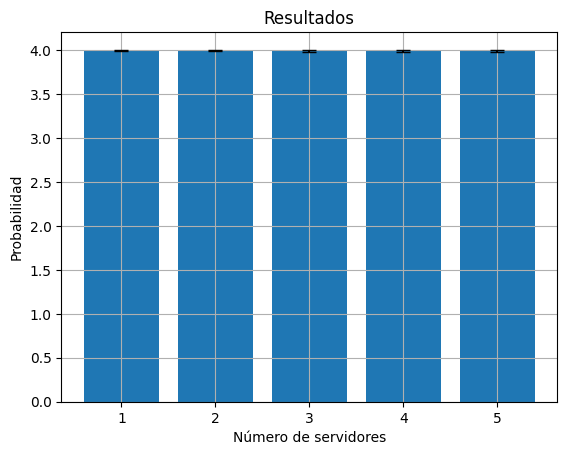

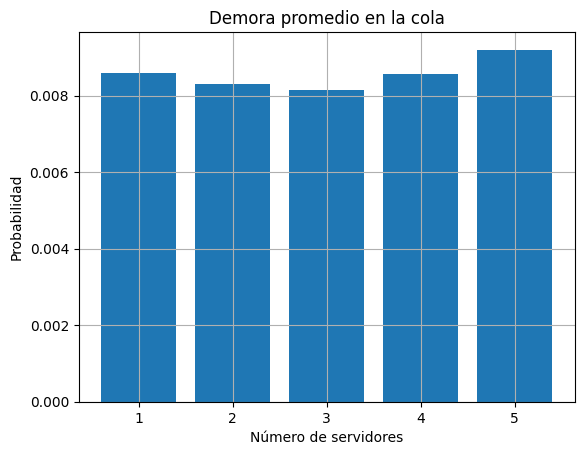

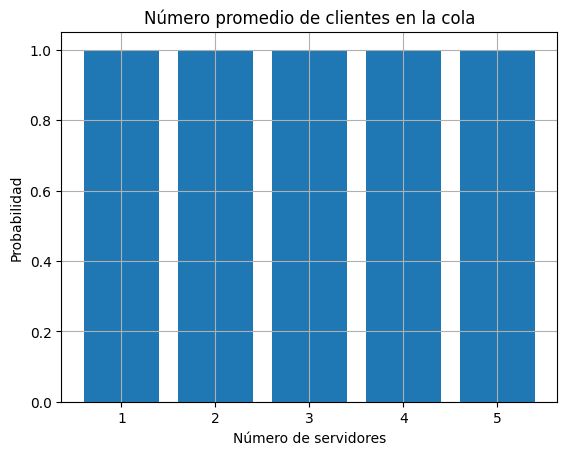

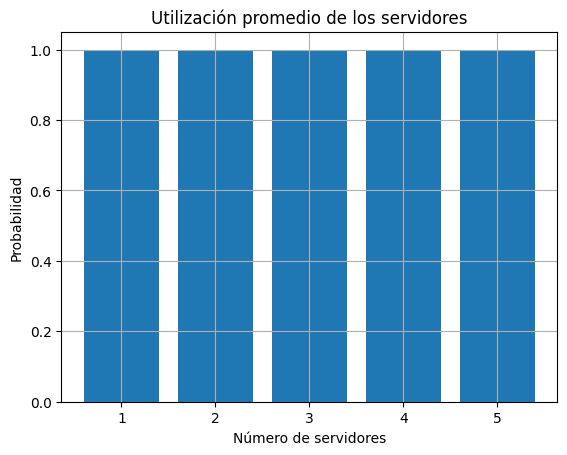

In [ ]:
def bar_diagram(x_data, y_data, y_err, graph_title):
    fig, ax = plt.subplots()

    if y_err:
        ax.bar(x_data, y_data, yerr=y_err, capsize=5)
    else:
        ax.bar(x_data, y_data)

    ax.set_xlabel("Número de servidores")
    ax.set_ylabel("Promedio")
    ax.set_title(graph_title)
    ax.grid()
    plt.show()

bar_diagram(results["num_servers"], results["probabilities"], results["err_prob"], "Resultados")
bar_diagram(results["num_servers"], results["average_delays"], [], "Demora promedio en la cola")
bar_diagram(results["num_servers"], results["average_customers"], [], "Número promedio de clientes en la cola")
bar_diagram(results["num_servers"], results["average_utilizations"], [], "Utilización promedio de los servidores")